In [24]:
from selenium.webdriver.firefox.firefox_binary import FirefoxBinary
from selenium import webdriver
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from bs4 import BeautifulSoup
import time

def checkgeneexists(cookiezi, driver):
    
    #driver = webdriver.Firefox()
                                 #if not working (not in env variables), paste in executable path to geckodriver.exe file
                                 #executable_path=r'C:\Users\Kevin\geckodriver-v0.29.1-win64\geckodriver.exe')
        
    replace = "https://www.genecards.org/cgi-bin/carddisp.pl?gene=" + cookiezi
    driver.get(replace)
    time.sleep(2)
    
    dog = driver.find_elements_by_id("aliases_descriptions")
    
    cat = 0
    vaxei = "Target found"

    if not dog:
        driver.get("https://www.genecards.org/Search/Keyword?queryString=" + cookiezi)
        time.sleep(5)
        check = driver.find_elements_by_class_name("gc-gene-symbol")
        if check:
            replace = "https://www.genecards.org/cgi-bin/carddisp.pl?gene=" + driver.find_element_by_class_name("gc-gene-symbol").text
            vaxei = driver.find_element_by_class_name("gc-gene-symbol").text
            driver.get(replace)
            cat = 1
        else:
            vaxei = "Target does not exist, nor does it have related targets! Try again"
            cat = 2

    
    return replace, driver, cat, vaxei

##########################################################################################################


def genecards(osugame, woof): #osugame input will be a gene name
    #Test links:
    
    #driver = webdriver.Firefox(executable_path=r'C:\Users\Kevin\geckodriver-v0.29.1-win64\geckodriver.exe')
        
    source =  "https://www.genecards.org/cgi-bin/carddisp.pl?gene=" + osugame   

    source, driver, alternatesearch, newtarget = checkgeneexists(osugame, woof)
    
    n = 0
    
    if alternatesearch != 2:
        table = driver.find_element_by_id("aliases_descriptions")
        aliasnames = table.find_elements_by_tag_name("li")
        title = driver.find_element_by_tag_name("strong").text

        ensembl = ""
        mrekk = []
        check = 0
        
        
        for cat in aliasnames:
            cow = 0
            numbers = ""
            sups = cat.find_elements_by_tag_name("sup")
            if not sups:
                sups = cat.find_elements_by_class_name("gc-ga-link")
                cow = 1
            #print(cow)
            
        
            if cow == 0:
                for fish in sups:
                    numbers = numbers + " " + fish.text
            elif cow == 1:
                if ":" not in cat.text:
                    for fish in sups:
                        numbers = numbers + ", " + fish.text
                numbers = numbers[2:]
                numbers = " (" + numbers + ")"
            #print(cat.text)
            #print(numbers)
            if numbers!= "" and numbers!=" ()":
                #print(cat.text.split(numbers)[0])
                mrekk.append(str(cat.text[:-len(numbers)]))


            if "Ensembl" in cat.text: 
                ensembl = cat.text
                check = 1
            elif check == 0:
                ensembl = "ENSEMBL NOT FOUND"

        #print()
        ensembl = ensembl.split()[1]

        #driver.close()

        return ensembl,mrekk,title, driver, source, alternatesearch, newtarget
    
    else:
        
        return "","","", driver, "", alternatesearch, newtarget
    

############################################################################################
 

def getopentargets(genename, drivername): #genename will be a gene name

    ensemblname, aliases,name, nd, genecardslink, searchno, target2 = genecards(genename, drivername)
    link = ""
    woof = 0
    if searchno !=2:
        conditions = []
        if ensemblname == "NOT":
            nd.get("https://platform.opentargets.org/search?q=" + name + "&page=1")
            time.sleep(2)
            link = nd.find_element_by_class_name("jss28").get_attribute("href")
            woof = 1
        #print(link)
        
        driver = nd #webdriver.Firefox() #executable_path=r'C:\Users\Kevin\geckodriver-v0.29.1-win64\geckodriver.exe' #make sure this exists somewhere in a local, varies from user to user, and copy the path here
        
        if woof == 0:
            opentargetslink = "https://platform.opentargets.org/target/" + ensemblname + "/associations"
        else:
            opentargetslink = link
            
        if "ENSG00000105810" in link and genename!="CDK6":
                return [], aliases, name, genecardslink, "OpenTargets gene not found!", target2, nd
        
        driver.get(opentargetslink)
        time.sleep(4)

        results = driver.find_elements_by_class_name("MuiTableRow-root")
        if not results:
            time.sleep(2)
        elif  "Name" in results[0].text:
            results.pop(0)

        for result in results:
            product_name = result.find_element_by_tag_name('span')
            #print("                        " + product_name.text)
            conditions.append(product_name.text)

        search = ""
        if searchno == 1:
            search = "Original target not found, closest target found: " + target2
        elif searchno == 0:
            search = target2
        
        
        if len(conditions)>10:
            conditions = conditions[:10]
        

        return conditions, aliases, name, genecardslink, opentargetslink, search, nd
    
    else:
        
        #nd.close()
        return [], [], str(genename) + "?", "DNE", "DNE", target2, nd
    


In [26]:

doggie = ['SDR42E2', 'KLK12', 'KLK13', 'KLK14', 'KLK15', 'KLKB1', 'KLLN', 'KLRB1', 'KLRC1']
   
#################################################

'''
MOST COMMON "UNCOMMON" SCENARIOS ENCOUNTERED (FEEL FREE TO ADD MORE HERE)


expect GAGE4 to have a genecards.org page about it, but no ensembl code and is unsearchable on opentargets.org, 
therefore no page about it exists on opentargets.org
    solved by returning alias list but returning empty list for diseases/conditions
    
expect NALF1 to not have a genecards.org page about it, (implied) no ensembl code and therefore no opentargets.org page
    solved by default returning empty list for both aliases and diseases/conditions

expect GREP1 to have a genecards.org page about it, no ensembl code but it *is* searchable on opentargets.org,
therefore there is an opentargets.org page for it
    solved by returning the aliases list and diseases/conditions as usual
'''

print(len(doggie))
driver = webdriver.Firefox()
rajeevram = [] #list for diseases/conditions
joesalisbury = [] #list for aliases
cat = 0

while len(doggie)!=0:
    conditions, aliases, name, genecardslink, opentargetslink, search, driver = getopentargets(doggie[0], driver)
    cat = cat+1
    rajeevram.append(conditions)
    joesalisbury.append(aliases)
    print(doggie[0] + " " + name + " " + str(cat))
    print(conditions)
    print()
    doggie.pop(0)

driver.close()

print()
print("ALiases")
print(joesalisbury)

print()
print("Conditions")
print(rajeevram)



9
SDR42E2 SDR42E2 1
['heel bone mineral density']

KLK12 KLK12 2
['obesity', 'protein measurement', 'blood protein measurement', 'kallikrein-11 measurement', 'kallikrein-12 measurement', 'urinary bladder cancer', 'squamous cell lung carcinoma', 'endometrial cancer', 'neoplasm', 'triple-negative breast cancer']

KLK13 KLK13 3
['head and neck squamous cell carcinoma', 'glioblastoma multiforme', 'breast adenocarcinoma', 'prostate adenocarcinoma', 'cutaneous melanoma', 'clear cell renal carcinoma', 'gastric adenocarcinoma', 'lung adenocarcinoma', 'squamous cell lung carcinoma', 'endometrial cancer']

KLK14 KLK14 4
['blood protein measurement', 'sialic acid-binding Ig-like lectin 9 measurement', 'breast adenocarcinoma', 'prostate adenocarcinoma', 'clear cell renal carcinoma', 'gastric adenocarcinoma', 'esophageal cancer', 'neuroblastoma', 'male infertility', 'neoplasm']

KLK15 KLK15 5
['prostate specific antigen measurement', 'prostate carcinoma', 'prostate cancer', 'ovarian cancer', 'breas

In [ ]:
#To Excel spreadsheet

#side note when the ensembl doesn't exist it and it does the search on opentargets.org it doesnt
#guarantee the target can be found on the site since opentargets relies on the ensembl
#code to find the target/associations. The aliases likely do exist for every single gene, but if
#the ensembl doesn't then it picks from some random default search gene conditions/diseases,
#which is not right

#Example -> half the GAGE genes don't have ensembl codes anywhere online so they can't be found
#and searched on opentargets in the first place so it defaults to CDK6 diseases and conditions
    #->GREP1 doesn't have an ensembl code on genecards.org but its ensembl code exists online so
    #  it can be searched up and found on opentargets



uwu = [] #doggie
owo = [] #all list of lists (ie. all aliases lists)
df = pd.DataFrame(index = uwu, data = owo)
writer = pd.ExcelWriter('5k_to_10k_Conditions.xlsx', engine='xlsxwriter')
df.to_excel(writer, sheet_name='Conditions', index=True)
writer.save()

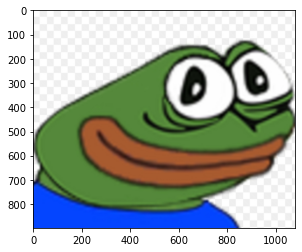

In [34]:
#okayge

import matplotlib.pyplot as plt

okayge = plt.imread("okayge.jpg")
plt.imshow(okayge)